* **Colab Link**
https://colab.research.google.com/drive/1y92DaWkkE-cCwklmttQsyjeqq10EKAFA#scrollTo=chFky2agOFBo

* **Github Link**
https://github.com/vincely-zz/MIE1517-Final-Project/tree/main

In [ ]:
import os
import random
import time
from itertools import cycle
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import interp, ndimage, misc
import skimage

from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, f1_score, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms

import cv2
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import seaborn as sns

import pixellib
from pixellib.tune_bg import alter_bg

from livelossplot import PlotLossesKeras

## **Problem Statement & Goal Descriptions**
To solve the lack of efficient-automated cats breeds identifying systems, we create such a model. Our model can highly reduce the cost of time and increase the accuracy of identify cats breeds compared to the traditional method of manually identifying.

Our model is vital to people like animal shelters employees and researchers. Animal shelters can improve the adoption rates by providing accurate breed information. Researchers can benefit from our system when doing genetic studies.

We have great interest in this because it easily lets people know about cat breeds through images or videos.

The following code shows our walkthrough of from data loading to implementation and prediction step-by-step.


## **Eda / Exploratory Data Analysis**


*   Raw Data Loading
*   Data Visualization



In [ ]:
!unzip /content/filtered_img.zip -d data_set

In [ ]:
filelist  = []

for dirname, _, filenames in os.walk('/content/data_set'):  ##File Path
    for filename in filenames:
        filelist.append (os.path.join(dirname, filename))

In [ ]:
len(filelist)   ##Check the length of total images

17611

In [ ]:
# set classes we want to train with
labels_needed = ['Bengal', 'Bombay', 'Calico', 'Dilute Tortoiseshell', 'Persian','Ragdoll','Russian Blue']  ##Cat breed labels

In [ ]:
Filepaths   = []
labels = []

for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    if label in labels_needed:

        Filepaths.append(image_file)
        labels.append(label)

In [ ]:
len(Filepaths), len(labels)

(17611, 17611)

In [ ]:
df = pd.DataFrame( list( zip (Filepaths, labels) ), columns = ['Filepath', 'Labels'] )
df = (df.sample(frac = 1).reset_index()).drop(columns = 'index')

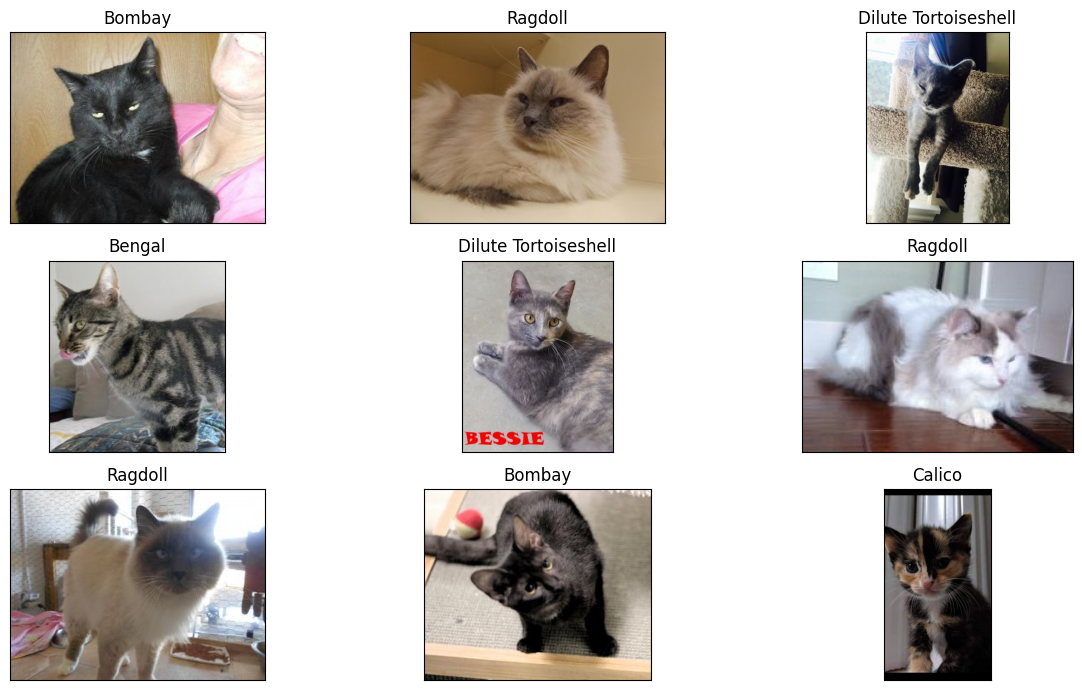

In [ ]:
# check image sample
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])

plt.tight_layout()
plt.show()

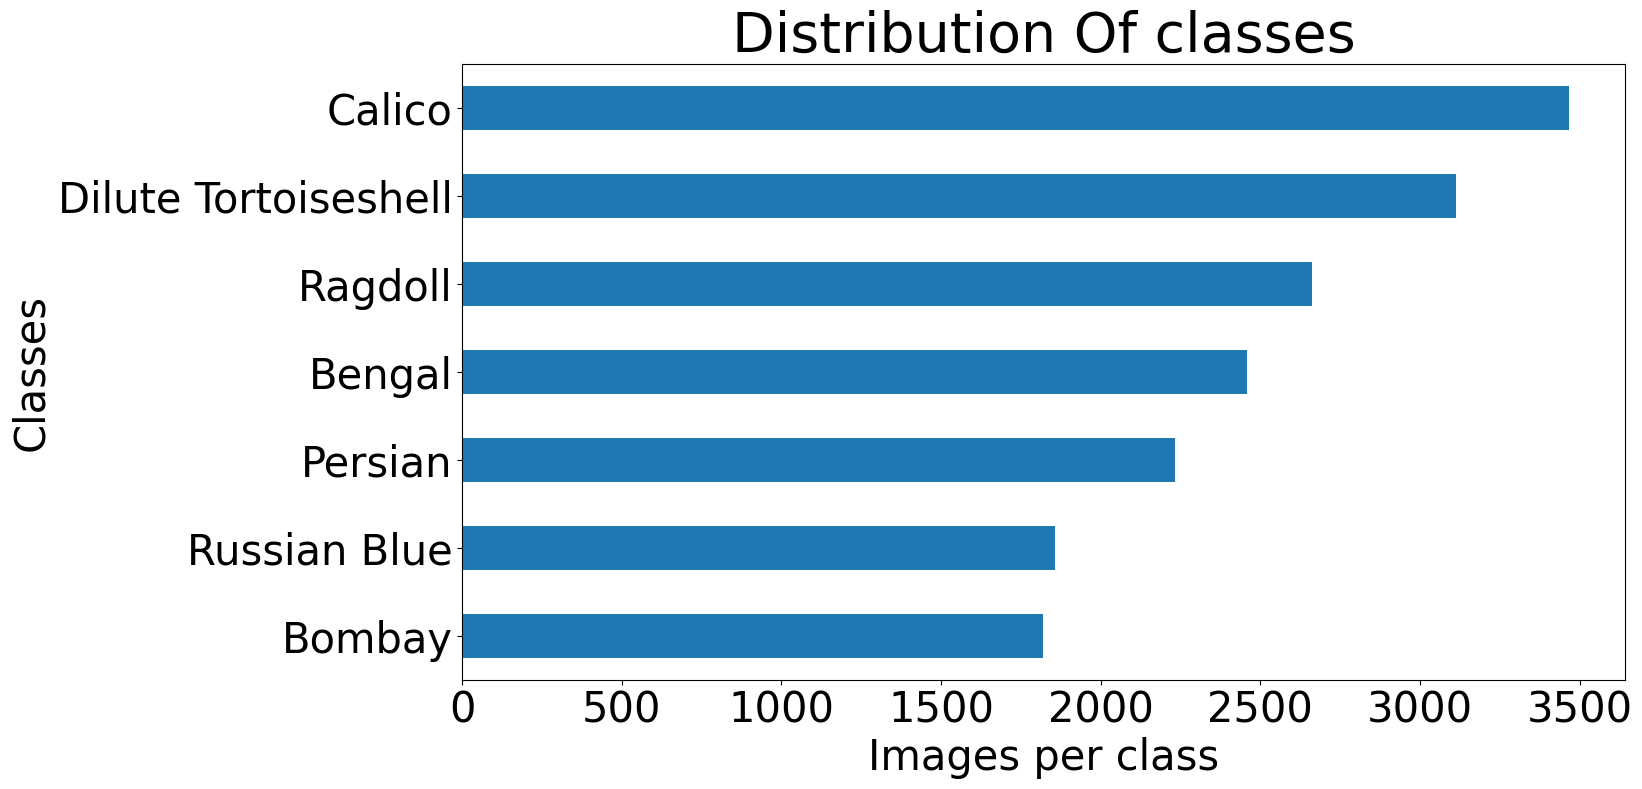

In [ ]:
# check distribution of classes in out data
ax=pd.value_counts(df['Labels'],ascending=True).plot(kind='barh',
                                                       fontsize="30",
                                                       title="Distribution Of classes",
                                                       figsize=(15,8))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(30)
ax.yaxis.label.set_size(30)
ax.title.set_size(40)
plt.show()

The dataset we use has 7 categories named Caloco, Dilute Tortoiseshell, Ragdoll, Bengal, Persian, Russian Blue, and Bombay. The number of each categories can be seen in the above plot and there is no obvious imbalance.


## **Data Pre-Processing**



*   Resized with Padding and Cropping
  *    Standardizes the size of input data for machine learning models
*   Removed background
  *    Reduces images noise and focuses the model's attention on the primary subjects of the images
*   Data Loading and Splitting
  * Loads optimizes memory usage and splitting into training, validation, and test sets.
*   Data Augmentation and Loaders
  * Increases the diversity of training data and preventing overfitting





In [ ]:
## Helper Functions

def resize_with_padding_crop(image, target_size):
    """
    Resizes an image to a specified target size by center crop.

    Parameters:
    image (PIL.Image): The original image to be resized.
    target_size (int): The size (in pixels) of the sides of the square frame into which
                       the image will be fitted. Both width and height of the padded
                       image will be equal to this value.

    Returns:
    PIL.Image: The resized and padded image fitting into a square of the specified target size.
    """

    # Calculate the new size while preserving the aspect ratio
    aspect_ratio = image.width / image.height
    new_width, new_height = image.width, image.height

    # Determine which dimension (width or height) is smaller relative to the target size
    if aspect_ratio > 1:  # width > height
        new_height = target_size
        new_width = int(new_height * aspect_ratio)
    else:  # height >= width
        new_width = target_size
        new_height = int(new_width / aspect_ratio)

    # Resize the image
    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

    # Create a blank square image with the target size
    padded_image = Image.new("RGB", (target_size, target_size), (0, 0, 0))

    # Calculate padding offsets
    left_padding = (target_size - resized_image.width) // 2
    top_padding = (target_size - resized_image.height) // 2

    # Paste the resized image onto the center of the blank square image
    padded_image.paste(resized_image, (left_padding, top_padding))

    return padded_image



def resize_with_padding(image, target_size):
    """
    Resizes an image to a specified target size while maintaining its aspect ratio and
    pads the resized image to fit into a square frame of the target size.

    Parameters:
    image (PIL.Image): The original image to be resized and padded.
    target_size (int): The size (in pixels) of the sides of the square frame into which
                       the image will be fitted. Both width and height of the padded
                       image will be equal to this value.

    Returns:
    PIL.Image: The resized and padded image fitting into a square of the specified target size.
    """
    # Calculate the new size while preserving the aspect ratio
    aspect_ratio = image.width / image.height
    new_width = int(target_size * aspect_ratio)
    new_height = int(target_size / aspect_ratio)

    # Use the larger dimension to resize the image
    if new_width <= target_size:
        resized_image = image.resize((new_width, target_size))
    else:
        resized_image = image.resize((target_size, new_height))

    # Create a blank image with the target size
    padded_image = Image.new("RGB", (target_size, target_size), (0, 0, 0))

    # Paste the resized image into the center of the blank image
    left_padding = (target_size - resized_image.width) // 2
    top_padding = (target_size - resized_image.height) // 2
    padded_image.paste(resized_image, (left_padding, top_padding))

    return padded_image



##### Resized with padding/cropping

In [ ]:
# Specify the source folder (containing class subfolders)
source_folder = "/content/data_set/filtered_img"
target_size = 240

# Optionally, specify a destination root folder
destination_root = "/content/resize_padding/"

# Create the destination root folder if it doesn't exist
if not os.path.exists(destination_root):
    os.makedirs(destination_root)

# Iterate through each subfolder in the source folder
for class_folder in os.listdir(source_folder):
    class_folder_path = os.path.join(source_folder, class_folder)

    # Check if it's a directory
    if os.path.isdir(class_folder_path):
        destination_folder = os.path.join(destination_root, class_folder)

        # Create the destination subfolder if it doesn't exist
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)

        # Iterate through each file in the subfolder
        for file_name in os.listdir(class_folder_path):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Construct the full file path
                file_path = os.path.join(class_folder_path, file_name)

                # Open the image
                image = Image.open(file_path)

                # Resize the image
                resized_image = resize_with_padding(image, target_size)

                # Save the resized image to the destination subfolder
                resized_image.save(os.path.join(destination_folder, file_name))

(-0.5, 298.5, 298.5, -0.5)

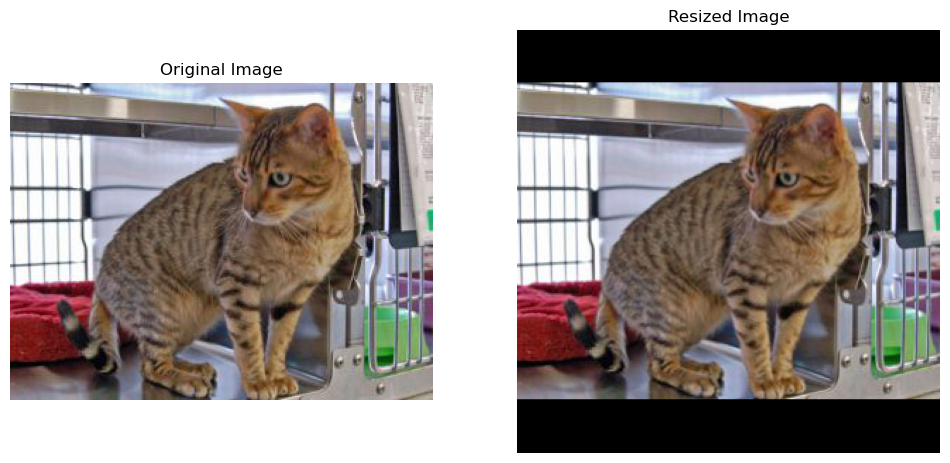

In [ ]:
#Test the resizing functions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(Image.open('/content/data_set/filtered_img/Bengal/16177789_9728.jpg'))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Image.open('/content/resize_padding/Bengal/16177789_9728.png'))
plt.title('Resized Image')
plt.axis('off')

#### Remove background

In [ ]:
change_bg = alter_bg(model_type = "pb")
change_bg.load_pascalvoc_model("xception_pascalvoc.pb")
# output = change_bg.color_bg("12136161_252.jpg",  colors=(255, 255, 255), detect='cat', verbose=1)
# cv2.imwrite("img.jpg", output)


# Specify the source folder (containing class subfolders)
source_folder = "/content/resize_padding/"
target_size = 240

# Optionally, specify a destination root folder
destination_root = "/content/resize_nobg/"

# Create the destination root folder if it doesn't exist
if not os.path.exists(destination_root):
    os.makedirs(destination_root)

# Iterate through each subfolder in the source folder
for class_folder in os.listdir(source_folder):
    class_folder_path = os.path.join(source_folder, class_folder)

    # Check if it's a directory
    if os.path.isdir(class_folder_path):
        destination_folder = os.path.join(destination_root, class_folder)

        # Create the destination subfolder if it doesn't exist
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)

        # Iterate through each file in the subfolder
        for file_name in os.listdir(class_folder_path):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Construct the full file path
                file_path = os.path.join(class_folder_path, file_name)

                # Open the image
                image = Image.open(file_path)

                # Resize the image
                resized_image = resize_with_padding(image, target_size)
                file_name = file_name.split('.')[0] + '.png'

                # save resized padding image
                resized_image.save(os.path.join(destination_folder, file_name))

                # read resized image and remove background
                file_name_clean = os.path.join(destination_folder, 'clean_' + file_name.split('.')[0] + '.png')
                output = change_bg.color_bg(os.path.join(destination_folder, file_name), output_image_name=file_name_clean, colors=(255, 255, 255), detect='cat', verbose=1)
                cv2.imwrite(file_name_clean, output)
                # output = remove(resized_image)


(-0.5, 298.5, 298.5, -0.5)

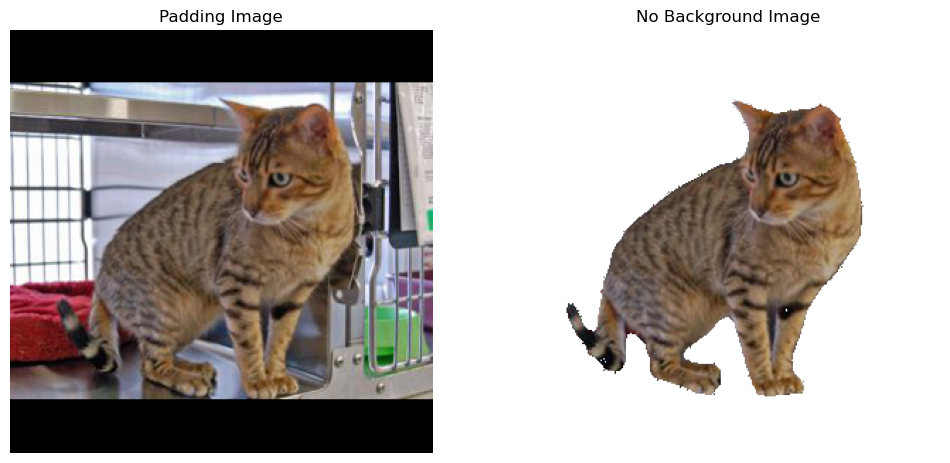

In [ ]:
#Test the padding functions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(Image.open('/content/resize_padding/Bombay/16177789_9728.png'))
plt.title('Padding Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Image.open('/content/resize_nobg/Bombay/clean_16177789_9728.png'))
plt.title('No Background Image')
plt.axis('off')

#### Data Loading and Splitting

We split the dataset into a train set (70%), a validation set (15%), and a test set (15%).

In [ ]:
# File loading
filelist = []
for dirname, _, filenames in os.walk('/content/resize_nobg'):
    for filename in filenames:
        filelist.append(os.path.join(dirname, filename).replace('\\', '/'))

# Filtering
labels_needed = ['Bengal', 'Bombay', 'Calico', 'Dilute Tortoiseshell', 'Persian','Ragdoll','Russian Blue']
Filepaths, labels = [], []
for image_file in filelist:
    label = image_file.split('/')[-2]
    if label in labels_needed:
        Filepaths.append(image_file)
        labels.append(label)

In [ ]:
# load all images and shuffle
df = pd.DataFrame(list(zip(Filepaths, labels)), columns=['Filepath', 'Label'])
df = df.sample(frac=1).reset_index(drop=True)

# Splitting
train_ratio, validation_ratio, test_ratio = 0.70, 0.15, 0.15
train, test = train_test_split(df, test_size=test_ratio)
val, test = train_test_split(test, test_size=test_ratio/(test_ratio + validation_ratio))

#### Data Augmentation and Loaders

In [ ]:
# Data augmentation and loaders
transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom dataset class
class CustomDataset(datasets.ImageFolder):
    def __init__(self, dataframe, label_to_int, transform=None):

        self.filepaths = dataframe['Filepath'].tolist()
        self.labels = dataframe['Label'].tolist()
        self.label_to_int = label_to_int
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Convert label from string to int
        label_str = self.labels[idx]
        label_int = self.label_to_int[label_str]

        return image, label_int

# Create label_to_int mapping
unique_labels = sorted(df['Label'].unique())
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

# Datasets
train_dataset = CustomDataset(train, label_to_int=label_to_int, transform=transform)
val_dataset = CustomDataset(val, label_to_int=label_to_int, transform=transform)
test_dataset = CustomDataset(test, label_to_int=label_to_int, transform=transform)

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## **Model Building and Training**





#### Using Pre-trained Model EfficientNet_b1




In [ ]:
# Model
class CustomModel1(nn.Module):
    def __init__(self, dropout_rate):
        super(CustomModel1, self).__init__()
        self.efficientnet = models.efficientnet_b1(pretrained=True)

        # decide whether to retrain weights for efficient net
        for param in self.efficientnet.parameters():
            param.requires_grad = True

        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # Remove the final FC layer

        # Additional Conv and Pooling layers
        self.fc1 = nn.Linear(num_ftrs, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.fc2 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.efficientnet(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


#### Model Architecture chart  
For the model archiecture, we use efficientNetB1 as the pretrained model, remove the final FC layer from
efficientNet to get the feature map, then connect that to two FC layers.  
The first one reduces the number of features
from 1280 to 512 and set activation to ReLU, then connects to a dropout layer,   
finally connect it to the second FC layer with out channel set to the number of classes, which is 7.

(-0.5, 2733.5, 701.5, -0.5)

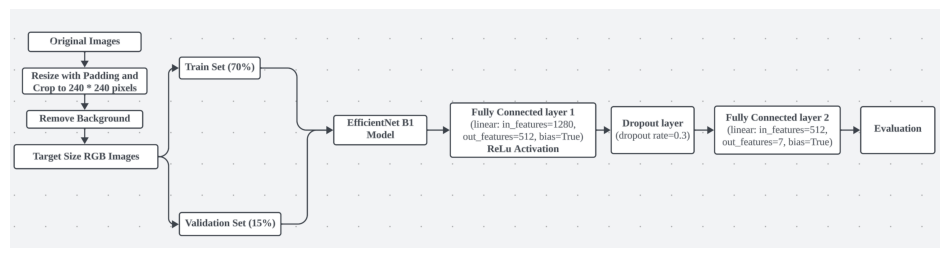

In [ ]:
# plot total workflow
plt.figure(figsize=(12, 6))
plt.imshow(Image.open('flowchart.png'))
plt.axis('off')

(-0.5, 2697.5, 1067.5, -0.5)

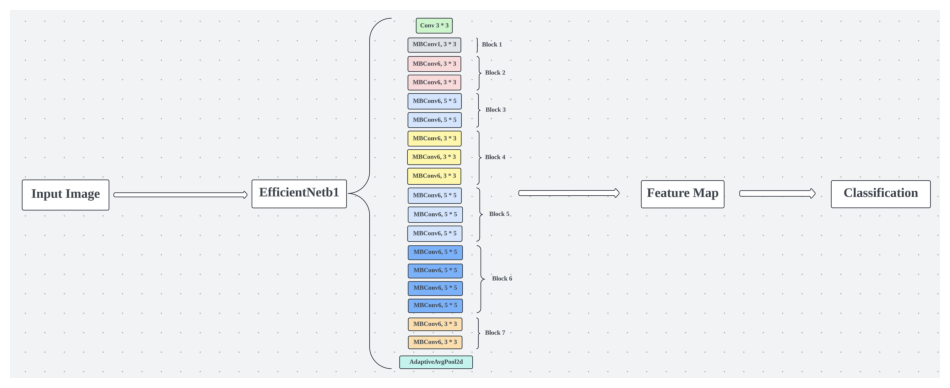

In [ ]:
# plot model architecture for efficientnet
plt.figure(figsize=(12, 6))
plt.imshow(Image.open('efficientNetb1.png'))
plt.axis('off')

#### Training Function

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=15, lr=0.001, step=7):
    """
    Trains a neural network model using provided training and validation data loaders.

    Parameters:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        num_epochs (int, optional): Number of epochs to train the model. Default is 15.
        lr (float, optional): Learning rate for the optimizer. Default is 0.001.
        step (int, optional): Step size for the learning rate scheduler. Default is 7.

    Returns:
        torch.nn.Module: The trained model.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=step, gamma=0.5)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        train_loss = 0.0
        train_corrects = 0

        # load training data and train
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                if isinstance(outputs, tuple):
                    outputs, aux_outputs = outputs
                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4 * loss2
                else:
                    loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                loss.backward()
                optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects.double() / len(train_loader.dataset)

        # use validation data to evaluate
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        train_losses.append(train_loss)
        train_accs.append(train_acc.item())
        val_losses.append(val_loss)
        val_accs.append(val_acc.item())

        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        scheduler.step()

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # Plotting the training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Acc')
    plt.plot(val_accs, label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    return model

> Training Model

Epoch 1/15
----------
Train Loss: 0.8181 Acc: 0.7185
Val Loss: 0.3953 Acc: 0.8697
Epoch 2/15
----------
Train Loss: 0.4000 Acc: 0.8662
Val Loss: 0.3305 Acc: 0.8924
Epoch 3/15
----------
Train Loss: 0.3305 Acc: 0.8876
Val Loss: 0.2878 Acc: 0.9084
Epoch 4/15
----------
Train Loss: 0.2819 Acc: 0.9032
Val Loss: 0.2300 Acc: 0.9235
Epoch 5/15
----------
Train Loss: 0.2442 Acc: 0.9175
Val Loss: 0.2223 Acc: 0.9282
Epoch 6/15
----------
Train Loss: 0.2214 Acc: 0.9255
Val Loss: 0.2363 Acc: 0.9239
Epoch 7/15
----------
Train Loss: 0.1915 Acc: 0.9358
Val Loss: 0.2176 Acc: 0.9282
Epoch 8/15
----------
Train Loss: 0.1720 Acc: 0.9424
Val Loss: 0.2139 Acc: 0.9307
Epoch 9/15
----------
Train Loss: 0.1557 Acc: 0.9466
Val Loss: 0.1837 Acc: 0.9412
Epoch 10/15
----------
Train Loss: 0.1427 Acc: 0.9498
Val Loss: 0.1915 Acc: 0.9382
Epoch 11/15
----------
Train Loss: 0.1139 Acc: 0.9607
Val Loss: 0.1712 Acc: 0.9408
Epoch 12/15
----------
Train Loss: 0.1018 Acc: 0.9653
Val Loss: 0.1860 Acc: 0.9437
Epoch 13/15
-

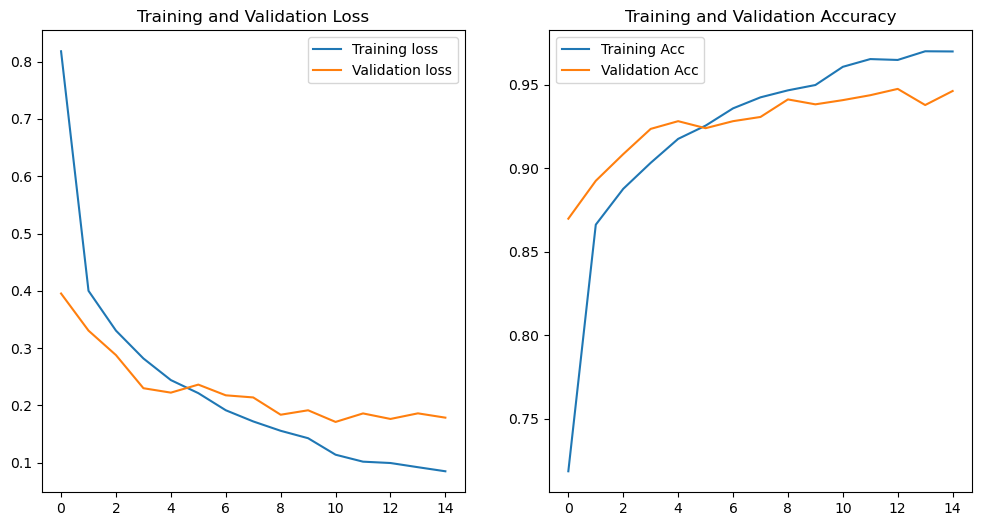

In [ ]:
num_epochs = 15
learning_rate = 0.002

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model1 = CustomModel1(0.3).to(device)

# Call the training function
eff_model = train_model(model1, train_loader, val_loader, num_epochs, learning_rate, step=10)

*  From the above plots, we can see that our model is well-balanced. The training and validation metrics indicate no overfitting or underfitting.

> Save the State Dictionary of the Trained model

In [ ]:
# save trained result
torch.save(eff_model.state_dict(), 'efficientnet_cat_breed_classifier_v1.pth')

## **Model Evaluation**


*   Accuracy on Test Set
*   Precision/Recall/f1-score
*   Confusion Matrix Plot
*   ROC Curve and AUC Scores

#### Accuracy on Test Set and Precision/Recall/f1-score

In [ ]:
eff_model.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []


with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = eff_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

class_report_dict = classification_report(all_labels, all_preds, target_names=labels_needed, output_dict=True)

class_report_df = pd.DataFrame(class_report_dict).transpose()

new_label_names = {
    "0": "Bengal",
    "1": "Bombay",
    "2": "Calico",
    "3": "Dilute Tortoiseshell",
    "4": "Persian",
    "5": "Ragdoll",
    "6": "Russian Blue"
}

# Rename the index
class_report_df.rename(index=new_label_names, inplace=True)


# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy in Test Data: {accuracy}")

print(class_report_df)


Accuracy in Test Data: 0.9457983193277311
                      precision    recall  f1-score      support
Bengal                 0.937173  0.944591  0.940867   379.000000
Bombay                 0.953488  0.957198  0.955340   257.000000
Calico                 0.981061  0.955720  0.968224   271.000000
Dilute Tortoiseshell   0.917004  0.949686  0.933059   477.000000
Persian                0.942029  0.953079  0.947522   341.000000
Ragdoll                0.963824  0.932500  0.947903   400.000000
Russian Blue           0.948000  0.929412  0.938614   255.000000
accuracy               0.945798  0.945798  0.945798     0.945798
macro avg              0.948940  0.946027  0.947361  2380.000000
weighted avg           0.946225  0.945798  0.945875  2380.000000


* Above output shows the accuracy of test data. Overall, the accuracy is about 95% with high precision recall and f1 scores across breeds. The output confirms the model's reliability and robust performance in real-world applications.

#### Confusion Matrix Plot


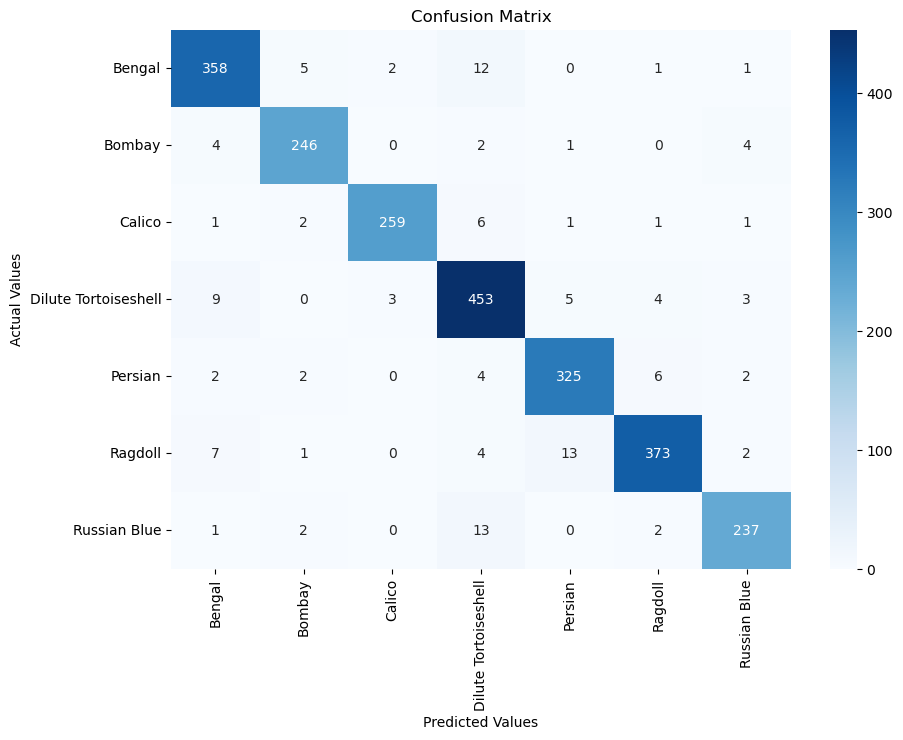

In [ ]:

class_names = ["Bengal", "Bombay", "Calico", "Dilute Tortoiseshell", "Persian", "Ragdoll", "Russian Blue"]

conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()

*  The confusion matrix reveals high true positive rates across breeds with minimum confusion between classes.

#### ROC Curve and AUC Scores

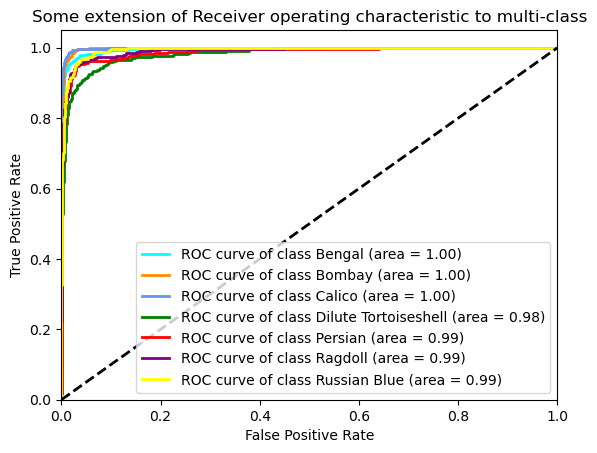

In [ ]:
softmax_probs = []

# Evaluate the model to get the softmax probabilities
eff_model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = eff_model(inputs)
        softmax_probs.append(outputs.cpu())

# Concatenate all batches
softmax_probs = torch.cat(softmax_probs, dim=0).numpy()

# Compute ROC curve and ROC area for each class
n_classes = len(labels_needed)  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert labels to one-hot encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
all_labels_one_hot = enc.fit_transform(all_labels.reshape(-1, 1)).toarray()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], softmax_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_one_hot.ravel(), softmax_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
lw = 2  # Line width
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(labels_needed[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Binarize the labels for the One-vs-Rest computation
y_bin = label_binarize(all_labels, classes=range(n_classes))

# Calculate the AUC for each class
auc_scores = {}
for i in range(n_classes):
    auc_scores[labels_needed[i]] = roc_auc_score(y_bin[:, i], softmax_probs[:, i])

# Calculate the macro-average AUC score
macro_auc_score = roc_auc_score(y_bin, softmax_probs, multi_class="ovr", average="macro")

auc_df = pd.DataFrame(list(auc_scores.items()), columns=['Class', 'AUC Score'])

# Add a row for the macro-average AUC
auc_df = pd.concat([auc_df, pd.DataFrame({'Class': ['Macro-average'], 'AUC Score': [macro_auc_score]})], ignore_index=True)

# Set the class names as the index
auc_df.set_index('Class', inplace=True)

print(auc_df)


                      AUC Score
Class                          
Bengal                 0.995353
Bombay                 0.997599
Calico                 0.998908
Dilute Tortoiseshell   0.982138
Persian                0.987720
Ragdoll                0.990913
Russian Blue           0.993873
Macro-average          0.992358


* From the above ROC curve plot and AUC scores across different cats breeds, we can see all values are near to 1. This demonstrate the model's strong discriminatory capability between breeds.

## Interesting findings on the model

This image features a Ragdoll cat having its head obstructed by an object. If we ignore the head of a Ragdoll, there is a high likelihood that we could confuse it with a Persian cat because of its plentiful long hair. Hence, to obtain the most precise predictions from our model, the original image must encompass crucial characteristics that differentiate one breed from another. (In this instance, head). Otherwise, as a result of the resemblance among these several breeds, the model is highly likely to misclassify it.

In [ ]:
def process_image(image_path):
    """
    This function processes an image to detect cats using a pre-trained YOLO model and classifies
    their breeds using our classification model.

    Parameters:
    image_path (str): The path to the image file to be processed.
    """
    # Load the image
    frame = cv2.imread(image_path)
    frame = cv2.resize(frame, (700, 600))
    height, width, _ = frame.shape

    # Convert frame to blob for YOLO
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    yolo_net.setInput(blob)
    outs = yolo_net.forward(layer_names)

    # Post-process the detections
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5 and class_id == 15:  # Class ID for cat in COCO dataset
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)


    # Define breed labels for classification model
    breed_labels = ['Bengal', 'Bombay', 'Calico', 'Dilute Tortoiseshell', 'Persian', 'Ragdoll', 'Russian Blue']
    # Replace the above list with actual breed labels

    # Image transformation for breed classification model
    transform = transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Process each detected cat
    for i in cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4).flatten():
        box = boxes[i]
        x, y, w, h = box

        # Extract cat image
        cat_image = frame[y:y+h, x:x+w]

        # Convert to PIL Image
        cat_image_pil = Image.fromarray(cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB))

        # Apply transformations
        cat_image_tensor = transform(cat_image_pil).unsqueeze(0).to(device)

        # Classify the breed
        with torch.no_grad():
            outputs = model(cat_image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            top_prob, top_cat_id = torch.topk(probabilities, 1)

        breed = breed_labels[top_cat_id[0]]  # Get the predicted breed label
        probability = round(top_prob.item(), 2)

        # Draw bounding box and label on the image
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(frame, f"{breed}: {probability}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Resize the image for display
    scale_percent = 70  # Percentage of the original size
    width = int(frame.shape[1] * scale_percent / 100)
    height = int(frame.shape[0] * scale_percent / 100)
    dim = (width, height)

    # Resize image
    resized_frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

    # Display the resulting frame
    cv2_imshow(resized_frame)

In [ ]:
# Load YOLO model for cat detection
yolo_net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
layer_names = yolo_net.getUnconnectedOutLayersNames()

# Load the classification model
model = CustomModel1(0.3)
model.load_state_dict(torch.load('/content/efficientnet_cat_breed_classifier_v1.pth'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

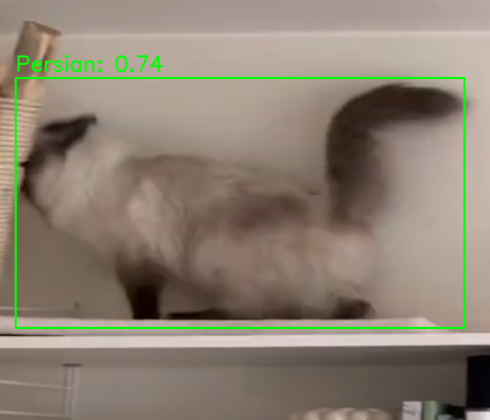

In [ ]:
image_paths = ['/content/test4.png']

# Process each image
for img_path in image_paths:
    process_image(img_path)

## Example of implementation on new data

For this part, we retrieve cat images from Google in a random manner, ensuring that the model hasn't come across these images previously. We are able to successfully classify the breed for each of these classes, which proves that our model can generalize well on new data and give correct predictions.

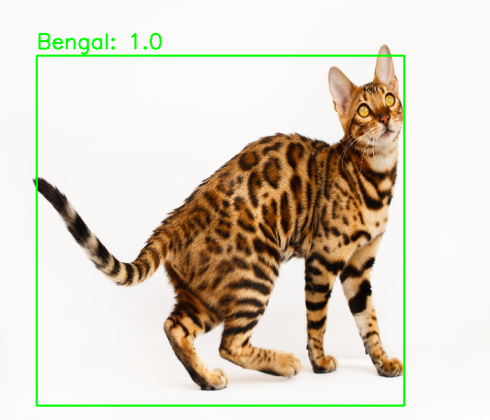

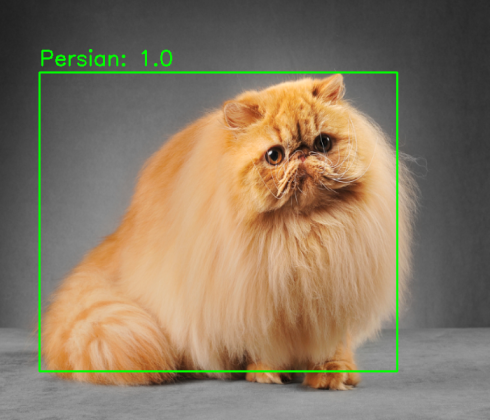

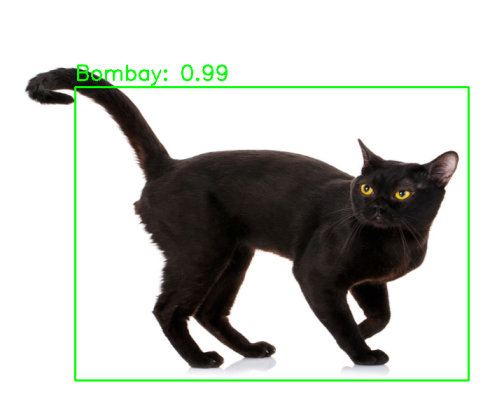

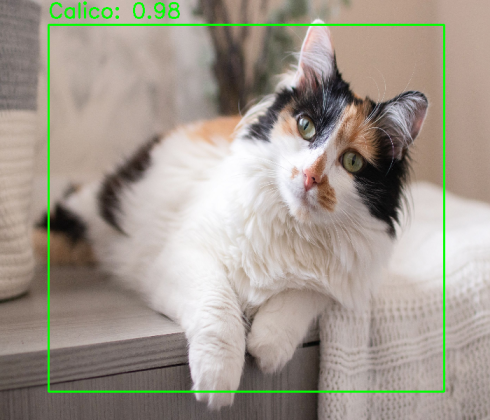

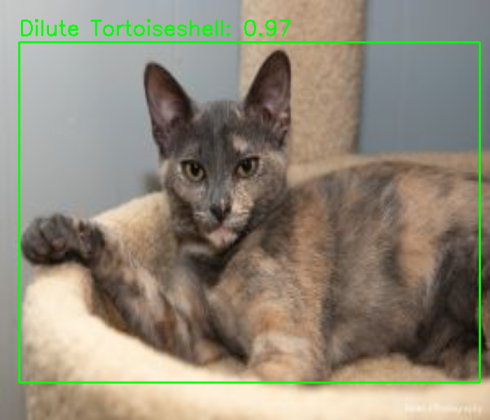

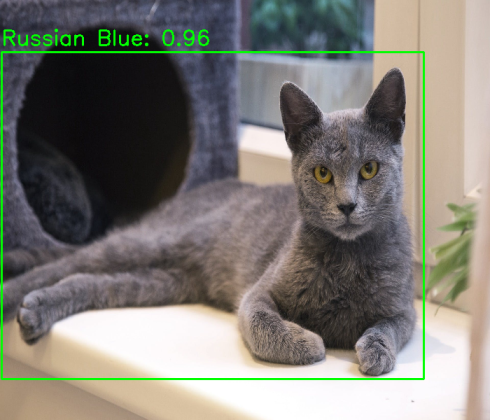

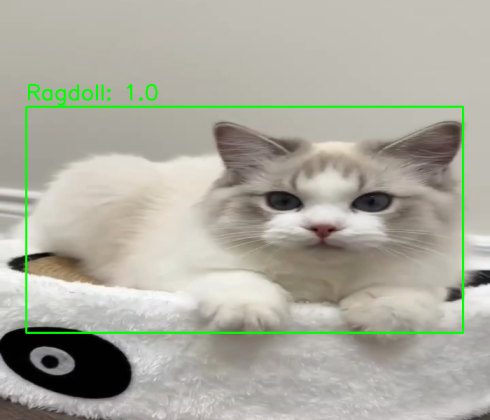

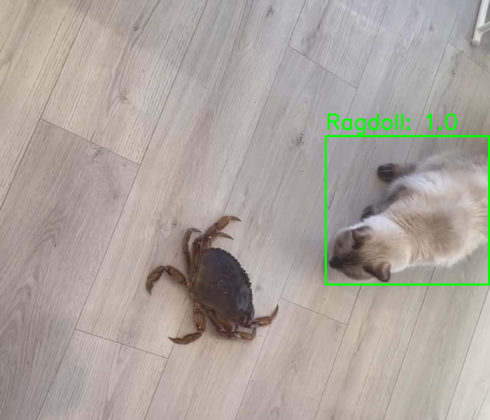

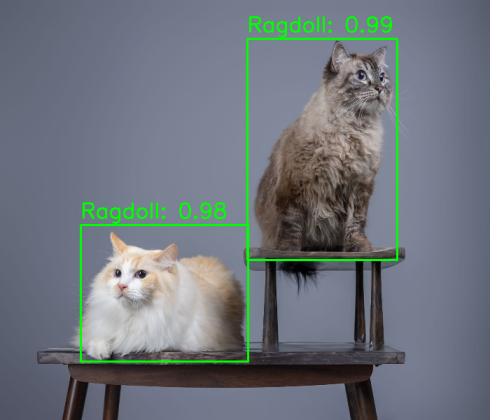

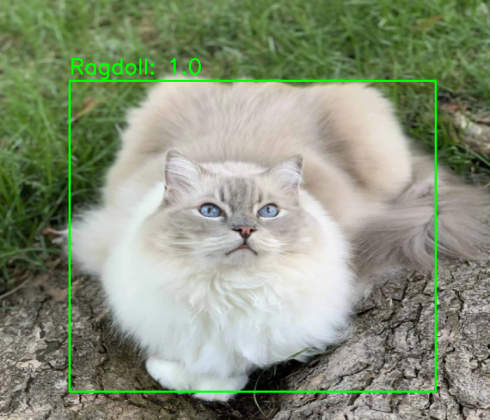

In [ ]:
# List of image paths to process
image_paths = ['/content/Bengal.png', '/content/Persian.png','/content/Bombay.png', '/content/Calico.png','/content/Tor.jpg','/content/RussianBlue.jpg','/content/Ragdoll.jpg','/content/test1.jpg','/content/test2.jpg','/content/test3.png']

# Process each image
for img_path in image_paths:
    process_image(img_path)

### **Reload model and demo  / Demonstration in faster_rcnn**

In [ ]:
# Model
class CustomModel1(nn.Module):
    def __init__(self, dropout_rate):
        super(CustomModel1, self).__init__()
        self.efficientnet = models.efficientnet_b1(pretrained=True)
        for param in self.efficientnet.parameters():
            param.requires_grad = False

        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # Remove the final FC layer

        # Additional Conv and Pooling layers
        self.fc1 = nn.Linear(num_ftrs, 512)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.fc2 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.efficientnet(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [ ]:
model_trained = CustomModel1(0.2)  # Make sure this matches your model's architecture
model_trained.load_state_dict(torch.load('efficientnet_cat_breed_classifier_v1.pth'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_trained = model_trained.to(device)
model_trained.eval()  # Set the model to evaluation mode

> Use video never used on the model for demo

In [ ]:

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode
model = model.to('cuda')

# Function to get predictions
def get_predictions(frame, threshold=0.2, nms_threshold=0.001):
    # transform the input frame from the video clip
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.ToTensor()
    ])
    frame = transform(frame).to('cuda')

    with torch.no_grad():
        prediction = model([frame])
    # Filter predictions for cats (class label 17 in COCO dataset)
    boxes = []
    scores = []
    if prediction[0]['boxes'] != []:
        for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
            if label == 17 and score > threshold:  # Check if label is 'cat' and score is above threshold
                boxes.append(box)
                scores.append(score)

    if boxes:
        # Convert to tensors
        boxes = torch.stack(boxes)
        scores = torch.tensor(scores).to('cuda')

        # Apply Non-Maximum Suppression
        keep = ops.nms(boxes, scores, nms_threshold)

        # Filter boxes after NMS
        final_boxes = boxes[keep]
    else:
        # If no boxes, return an empty list
        final_boxes = []

    return final_boxes


# Load video
cap = cv2.VideoCapture('./calico1.mp4')

# start playing video
while cap.isOpened():
    ret, frame = cap.read()
    height, width, _ = frame.shape
    if not ret:
        break

    # Get cat predictions for the frame
    cat_boxes = get_predictions(frame)

    # Draw bounding boxes around detected cats
    if cat_boxes != []:
        for box in cat_boxes:
            box = box.to('cpu')
            x, y, w, h = box
            x, y, w, h = int(x), int(y), int(w), int(h)
            print(x, y, w, h)
            x = max(0, x)
            y = max(0, y)
            h_1 =max(w, h)
            w_1 = max(w, h)
            cat_image = frame[y:min(y+h_1, height),x:min(x+w_1, width)]
            transform = transforms.Compose([
                transforms.Resize((240, 240)),  # Resize to the same size as during training
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            image = Image.fromarray(cat_image)
            image = transform(image)
            image = image.unsqueeze(0).to(device)

            with torch.no_grad():  # No need to calculate gradients
                outputs = model_trained(image)

                probabilities = F.softmax(outputs, dim=1)
                # get two top probable cat breeds
                top_probs, top_cats = torch.topk(probabilities, 2)
                print(top_probs, top_cats)

            # get the breed name from the class list and print on frame
            class_names = ['Bengal', 'Bombay', 'Calico', 'Dilute Tortoiseshell', 'Persian','Ragdoll','Russian Blue']
            for i in range(top_cats.size(1)):
                class_id = top_cats[0, i]
                probability = round(top_probs[0, i].item(), 2)
                if (i == 0) & (probability < 0.3):
                    cv2.putText(frame, 'Unknown/Unclear breed', (x+5, y + 20), cv2.FONT_HERSHEY_DUPLEX, 0.5, (0, 255, 0), 1)
                    break

                cv2.putText(frame, f"Breed: {class_names[class_id]} | {probability}", (x+5, y + (i+1)*30), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0), 2)
            cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 3)

    # Display the frame with detections
    cv2.imshow('Demo', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

**Video Avaliable Here:** https://www.dropbox.com/scl/fi/phokbucf3rllfwp87w0ho/demo.mp4?rlkey=ac2id1x9l34s7pq1kbvwfpddv&dl=0

## **Related work**

Medium post: https://medium.com/@dmitry.astankov/cat-breed-classification-with-deep-learning-169c66b3c478

The provided link goes to a Medium post authored by Dmitry Astankov, discussing the topic of cat breed classification using deep learning.
The Author also performed something similar to our approach. The distinction lies in his utilization of the resnet50 model as the pre-trained model, along with additional fully connected layers in the classifier.
In their example, a model was constructed to categorize 12 distinct cat breeds, yielding accuracy, precision, recall, and f1 score values all approximately equal to 0.85.
While our model outperforms theirs in terms of score, it is important to note that our dataset has 5 fewer breeds, which will certainly impact the level of difficulty.

## **Discussion**

### Results and Challenges:

The performance metrics of our cat breed classification model demonstrate robust accuracy and generalization. The AUC scores are high, with a macro-average near unity, indicating strong discriminative power. The ROC curves further corroborate this, displaying minimal false positive rates. Although the confusion matrix reveals occasional misclassifications, likely due to breed similarities, the overall high true positive rates reflect precise predictions. Precision, recall, and F1 scores are uniformly high, evidencing the model's reliability. Lastly, the converging training and validation loss, alongside consistent accuracy improvement, indicate a well-fitted model without substantial overfitting. These factors collectively affirm the model's effectiveness in accurately classifying various cat breeds.

In our project's final testing phase, we encountered classification challenges, particularly in distinguishing between similar breeds like Ragdolls and Persians in video footage. This issue arises from the genetic similarities between these breeds, as Ragdolls have Persian lineage. This genetic overlap leads to misclassification at certain angles or poses. As we expand our dataset to include more breeds, the challenge lies in accurately differentiating between breeds with close genetic and physical similarities. This underlines the need for a model capable of nuanced recognition, even in cases of closely related breeds.

Moreover, we encountered and resolved several data quality issues in our dataset, including the presence of duplicates, irrelevant images, and extraneous elements like adoption details or unrelated objects (e.g., tanks). By focusing on image preprocessing, such as cropping and background removal, we enhanced the model's ability to concentrate on the defining features of cats. This preprocessing step is crucial for improving the model's accuracy and efficiency in breed classification.


### What We Learned:
**The Importance of a Diverse Dataset:**

Our project emphasizes the significance of a diverse and comprehensive dataset, especially in complex classification tasks. The similarity between certain breeds (e.g., Ragdoll and Persian) highlights the necessity for a dataset that covers a wide range of breeds, ages, and physical characteristics. This diversity ensures that the model is well-trained to generalize across various breeds and age groups, thereby enhancing its classification accuracy.

**Balancing Computational Efficiency and Training Time:**

We dedicated considerable effort to selecting and optimizing a pre-trained model, balancing computational efficiency with performance. This aspect of the project taught us the importance of strategic model selection and data management. Allocating adequate time for training and choosing a model that balances accuracy with computational demands were key factors in achieving a successful outcome. This balance is vital in ensuring that the model is both effective and efficient in breed classification tasks.

**In Further**:

In our upcoming plans, we intend to expand the dataset by incorporating a wider variety of cat breeds and significantly increasing the volume of data. Our aim is to encompass images of each cat breed at various stages of their life cycle as comprehensively as possible. This expansion will involve not only gathering more diverse images but also revising and enhancing our model to better accommodate the increased diversity and complexity of the data. This could include implementing more advanced feature extraction techniques, tweaking the model architecture for greater depth or width, and employing more sophisticated data augmentation strategies to improve the model's generalization capabilities across different breeds and ages

# **Reference**

Dataset: https://www.kaggle.com/datasets/ma7555/cat-breeds-dataset/data
